# LSTM

https://github.com/soms98/Stock-Price-Prediction-Time-Series-LSTM-Model-Keras-Tensorflow/blob/master/HDFC.ipynb
https://www.youtube.com/watch?v=CbTU92pbDKw&t=1312s

https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# Import tensorflow packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors

# Displaying data
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Preprocessing data
from talib import abstract
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import math # Mathematical functions 


2023-04-29 21:43:24.231298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 21:43:24.292125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 21:43:24.293372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 21:43:25.371982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Project variabels

In [2]:
symbol = "EURUSD=X"
interval ='5m'
period = '1mo'

train_size_fraction = 0.70

## Download data

In [3]:
def getHistoryYfinance(symbol, interval, period):

    data = yf.download(  # or pdr.get_data_yahoo(...
    # Yahoo finance symbol
    tickers = symbol,

    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    period = period,

    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval = interval,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by = 'ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust = False,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost = False,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads = True,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy = None
    )
    
    data["returns"] = data['Close'] / data['Close'].shift(1)
    data.drop(['Adj Close', 'Volume'], axis='columns', inplace=True)
    data.dropna(inplace=True)
    
    return data  

In [4]:
Data_Raw = getHistoryYfinance(symbol, interval, period)
Data_Raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,returns
Datetime,,,,,
2023-03-29 00:05:00+01:00,1.084246,1.084363,1.084246,1.084246,0.999675
2023-03-29 00:10:00+01:00,1.084246,1.084246,1.084011,1.084011,0.999783
2023-03-29 00:15:00+01:00,1.084481,1.084481,1.084011,1.084128,1.000108
2023-03-29 00:20:00+01:00,1.084128,1.084246,1.084128,1.084246,1.000108
2023-03-29 00:25:00+01:00,1.084246,1.084363,1.084128,1.084363,1.000108


## Display data

Text(0.5, 1.0, 'EURUSD=X Close Price')

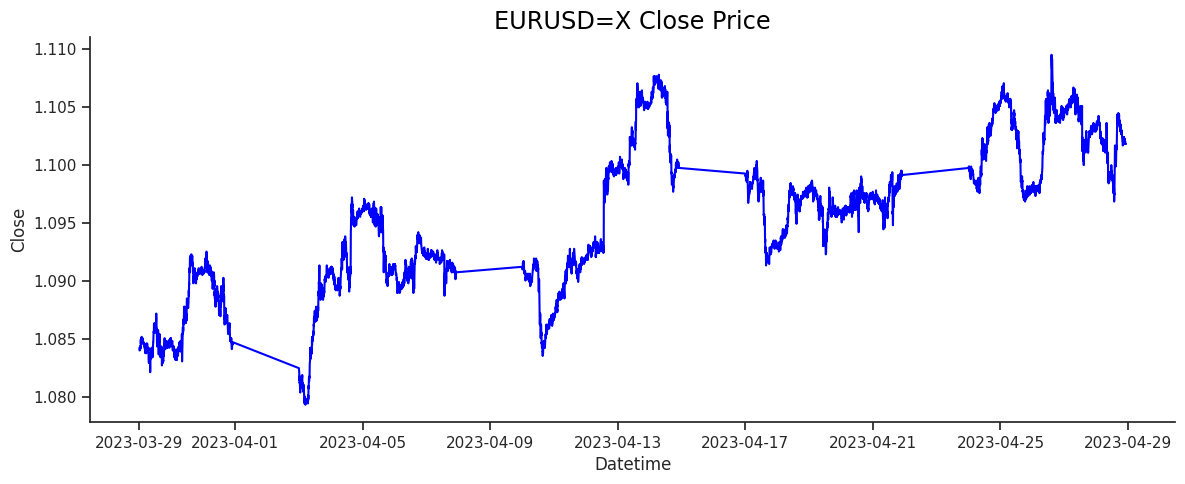

In [5]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=Data_Raw,x="Datetime",y='Close',color='blue')
sns.despine()
plt.title(symbol + ' Close Price',size='x-large',color='black')

## Create features

In [6]:
def prepare_features(data):
    ''' Prepares the feature columns for training set and test set.
    '''
    feature_columns = []
    lags = 5
    
    for lag in range(1, lags + 1):
        col = "lag{}".format(lag)
        data[col] = data["returns"].shift(lag)
        feature_columns.append(col)
        
    data['Ask_Dir'] = np.where(data['Close'].shift(-1) > data.Close, 1, 0)
    feature_columns.append('Ask_Dir')

    data['SMA'] = abstract.SMA(data['Close'], timeperiod=12)
    feature_columns.append('SMA')
    data['SMA_Dir'] = np.where(data['SMA'].shift(-1) > data.SMA, 1, 0)
    feature_columns.append('SMA_Dir')

    data['RSI'] = abstract.RSI(data['Close'], timeperiod=12)
    feature_columns.append('RSI')
    data['RSI_Dir'] = np.where(data['RSI'].shift(-1) > data.RSI, 1, 0)
    feature_columns.append('RSI_Dir')
    
    data['fastk'], data['fastd'] = abstract.STOCHRSI(data["Close"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    feature_columns.append('fastk')
    feature_columns.append('fastd')
    data['fastk_Dir'] = np.where(data['fastk'].shift(-1) > data.fastk, 1, 0)
    feature_columns.append('fastk_Dir')
    data['fastd_Dir'] = np.where(data['fastd'].shift(-1) > data.fastd, 1, 0)    
    feature_columns.append('fastd_Dir')
        
    data.dropna(inplace=True)
    
    return data, feature_columns

Data_Processed, feature_columns = prepare_features(Data_Raw)

In [7]:
Data_Processed.head()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
Datetime,,,,,,,,,,,,,,,,,,,
2023-03-29 01:45:00+01:00,1.084952,1.085187,1.084952,1.084952,0.999783,1.000326,0.999891,1.000109,1.000108,0.999675,0,1.084785,1,57.842873,0,0.586666,37.152607,0,0
2023-03-29 01:50:00+01:00,1.084952,1.084952,1.084834,1.084952,1.000000,0.999783,1.000326,0.999891,1.000109,1.000108,0,1.084834,1,57.842873,1,0.586666,33.724444,0,0
2023-03-29 01:55:00+01:00,1.085187,1.085187,1.084952,1.084952,1.000000,1.000000,0.999783,1.000326,0.999891,1.000109,1,1.084893,1,57.842873,1,0.586666,0.586666,1,1
2023-03-29 02:00:00+01:00,1.084952,1.085423,1.084952,1.085069,1.000108,1.000000,1.000000,0.999783,1.000326,0.999891,0,1.084903,1,60.319064,0,39.240342,13.471224,0,0
2023-03-29 02:05:00+01:00,1.084952,1.085069,1.084952,1.084952,0.999892,1.000108,1.000000,1.000000,0.999783,1.000326,0,1.084932,0,56.686751,0,0.000000,13.275669,0,0


In [8]:
Data_Processed.tail()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
Datetime,,,,,,,,,,,,,,,,,,,
2023-04-28 22:05:00+01:00,1.101807,1.101807,1.101807,1.101807,1.0,0.99989,0.99989,1.00000,1.00011,1.00000,0,1.101959,0,41.09363,0,1.372204e-13,2.810760e+00,0,0
2023-04-28 22:10:00+01:00,1.101807,1.101807,1.101807,1.101807,1.0,1.00000,0.99989,0.99989,1.00000,1.00011,0,1.101928,0,41.09363,0,0.000000e+00,5.921189e-16,1,1
2023-04-28 22:15:00+01:00,1.101807,1.101807,1.101807,1.101807,1.0,1.00000,1.00000,0.99989,0.99989,1.00000,0,1.101928,0,41.09363,1,2.806042e-13,9.412685e-14,0,0
2023-04-28 22:20:00+01:00,1.101807,1.101807,1.101807,1.101807,1.0,1.00000,1.00000,1.00000,0.99989,0.99989,0,1.101928,0,41.09363,0,0.000000e+00,4.838673e-14,0,0
2023-04-28 22:25:00+01:00,1.101807,1.101807,1.101807,1.101807,1.0,1.00000,1.00000,1.00000,1.00000,0.99989,0,1.101888,0,41.09363,0,0.000000e+00,4.838673e-14,0,0


In [9]:
Data_Processed.describe()

,Open,High,Low,Close,returns,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
count,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6511.000000,6.511000e+03,6511.000000,6511.000000
mean,1.095262,1.095443,1.095118,1.095266,1.000002,1.000002,1.000002,1.000002,1.000002,1.000002,0.407004,1.095251,0.484104,50.678456,0.448933,49.079019,4.908981e+01,0.377208,0.429888
std,0.006387,0.006387,0.006384,0.006387,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,0.491313,0.006377,0.499786,10.828445,0.497423,41.651437,3.113108e+01,0.484725,0.495098
min,1.079214,1.079331,1.079214,1.079331,0.997355,0.997355,0.997355,0.997355,0.997355,0.997355,0.000000,1.079593,0.000000,11.847248,0.000000,0.000000,-2.415845e-13,0.000000,0.000000
25%,1.090810,1.090988,1.090631,1.090750,0.999890,0.999890,0.999890,0.999890,0.999890,0.999890,0.000000,1.090795,0.000000,43.740888,0.000000,0.000000,2.330703e+01,0.000000,0.000000
50%,1.095890,1.096131,1.095770,1.095890,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.095921,0.000000,50.649945,0.000000,46.397199,4.801838e+01,0.000000,0.000000
75%,1.099505,1.099626,1.099324,1.099505,1.000111,1.000111,1.000111,1.000111,1.000111,1.000111,1.000000,1.099415,1.000000,57.882816,1.000000,100.000000,7.457605e+01,1.000000,1.000000
max,1.109139,1.109509,1.109139,1.109509,1.005603,1.005603,1.005603,1.005603,1.005603,1.005603,1.000000,1.108433,1.000000,88.176754,1.000000,100.000000,1.000000e+02,1.000000,1.000000


In [10]:
Data_Processed.dtypes

Open         float64
High         float64
Low          float64
Close        float64
returns      float64
lag1         float64
lag2         float64
lag3         float64
lag4         float64
lag5         float64
Ask_Dir        int64
SMA          float64
SMA_Dir        int64
RSI          float64
RSI_Dir        int64
fastk        float64
fastd        float64
fastk_Dir      int64
fastd_Dir      int64
dtype: object

In [11]:
print(feature_columns)

['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd', 'fastk_Dir', 'fastd_Dir']


In [12]:
df = Data_Processed.sort_values(by=['Datetime']).copy()
data = pd.DataFrame(df)
data_filtered = data[feature_columns]

In [13]:
# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = df['returns']

## Scaling data

In [ ]:
data_filtered.columns

In [14]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)


(6511, 14)


In [15]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

In [16]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['returns'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

## Split data into training and test

In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 5

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]


In [45]:
type(np_data_scaled)

numpy.ndarray

In [19]:
# Prediction Index
index_target = df.columns.get_loc("returns")

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_target]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)




In [44]:
pd_test = 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.347346,0.294040,0.307373,0.267367,0.360703,0.0,0.678924,1.0,0.611928,0.0,4.965207e-01,2.307199e-01,0.0,1.0
1,0.320690,0.347346,0.294040,0.307373,0.267367,1.0,0.681365,1.0,0.575616,1.0,2.089131e-01,3.003576e-01,1.0,1.0
2,0.307359,0.320690,0.347346,0.294040,0.307373,1.0,0.685204,1.0,0.674783,1.0,1.000000e+00,5.684779e-01,1.0,1.0
3,0.374023,0.307359,0.320690,0.347346,0.294040,1.0,0.688000,1.0,0.750383,1.0,1.000000e+00,7.363044e-01,0.0,1.0
4,0.374039,0.374023,0.307359,0.320690,0.347346,0.0,0.693597,1.0,0.872040,0.0,1.000000e+00,1.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,0.307338,0.307327,0.320690,0.334055,0.320690,0.0,0.775516,0.0,0.383160,0.0,1.372204e-15,2.810760e-02,0.0,0.0
1303,0.320690,0.307338,0.307327,0.320690,0.334055,0.0,0.774463,0.0,0.383160,0.0,0.000000e+00,2.421766e-15,1.0,1.0
1304,0.320690,0.320690,0.307338,0.307327,0.320690,0.0,0.774463,0.0,0.383160,1.0,2.806042e-15,3.357114e-15,0.0,0.0
1305,0.320690,0.320690,0.320690,0.307338,0.307327,0.0,0.774463,0.0,0.383160,0.0,0.000000e+00,2.899713e-15,0.0,0.0


In [20]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5204, 5, 14) (5204,)
(1302, 5, 14) (1302,)


In [21]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_target])
print(y_train[0])

0.29438703078314177
0.29438703078314177


In [22]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

70 5 14


2023-04-29 21:43:30.606815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 21:43:30.610216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 21:43:30.613258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [23]:
# Training the model
#epochs = 50
epochs = 5
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/5


2023-04-29 21:43:31.433959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 21:43:31.436354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 21:43:31.438424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

323/326 [============================>.] - ETA: 0s - loss: 0.0023

2023-04-29 21:43:38.717056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 21:43:38.719870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 21:43:38.721541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

326/326 [==============================] - 8s 12ms/step - loss: 0.0023 - val_loss: 9.1826e-04
Epoch 2/5
326/326 [==============================] - 3s 9ms/step - loss: 7.9630e-04 - val_loss: 8.2098e-04
Epoch 3/5
326/326 [==============================] - 3s 8ms/step - loss: 7.2903e-04 - val_loss: 9.8483e-04
Epoch 4/5
326/326 [==============================] - 3s 8ms/step - loss: 6.9361e-04 - val_loss: 7.1345e-04
Epoch 5/5
326/326 [==============================] - 3s 8ms/step - loss: 6.7448e-04 - val_loss: 7.3132e-04


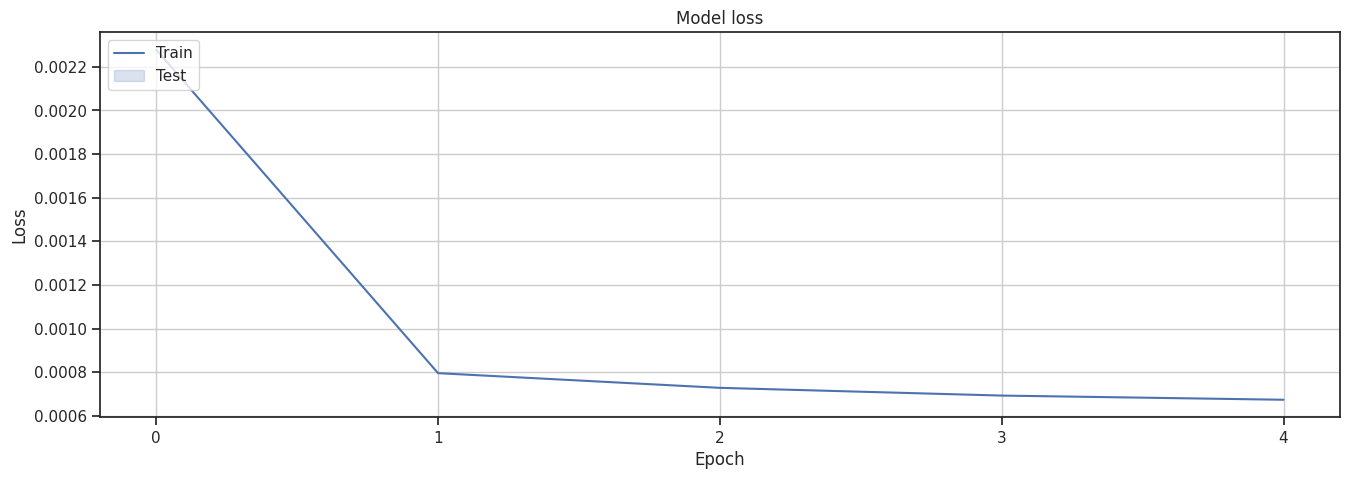

In [24]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Get the predicted values

In [25]:

y_pred_scaled = model.predict(x_test)

2023-04-29 21:43:51.336804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 21:43:51.339665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 21:43:51.342148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

41/41 [==============================] - 1s 3ms/step


# Unscale the predicted values

In [26]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 0.0
Mean Absolute Percentage Error (MAPE): 0.02 %
Median Absolute Percentage Error (MDAPE): 0.01 %


In [41]:
 y_test_unscaled

array([[1.        ],
       [0.99989004],
       [1.0004399 ],
       ...,
       [1.        ],
       [0.99988977],
       [0.99988987]])

In [28]:
data_filtered_ext

,lag1,lag2,lag3,lag4,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir,Prediction
Datetime,,,,,,,,,,,,,,,
2023-03-29 01:45:00+01:00,1.000326,0.999891,1.000109,1.000108,0.999675,0,1.084785,1,57.842873,0,5.866658e-01,3.715261e+01,0,0,0.999783
2023-03-29 01:50:00+01:00,0.999783,1.000326,0.999891,1.000109,1.000108,0,1.084834,1,57.842873,1,5.866658e-01,3.372444e+01,0,0,1.000000
2023-03-29 01:55:00+01:00,1.000000,0.999783,1.000326,0.999891,1.000109,1,1.084893,1,57.842873,1,5.866658e-01,5.866658e-01,1,1,1.000000
2023-03-29 02:00:00+01:00,1.000000,1.000000,0.999783,1.000326,0.999891,0,1.084903,1,60.319064,0,3.924034e+01,1.347122e+01,0,0,1.000108
2023-03-29 02:05:00+01:00,1.000108,1.000000,1.000000,0.999783,1.000326,0,1.084932,0,56.686751,0,0.000000e+00,1.327567e+01,0,0,0.999892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28 22:05:00+01:00,0.999890,0.999890,1.000000,1.000110,1.000000,0,1.101959,0,41.093630,0,1.372204e-13,2.810760e+00,0,0,1.000000
2023-04-28 22:10:00+01:00,1.000000,0.999890,0.999890,1.000000,1.000110,0,1.101928,0,41.093630,0,0.000000e+00,5.921189e-16,1,1,1.000000
2023-04-28 22:15:00+01:00,1.000000,1.000000,0.999890,0.999890,1.000000,0,1.101928,0,41.093630,1,2.806042e-13,9.412685e-14,0,0,1.000000


In [39]:
# The date from which on the date is displayed
display_start_date = "2023-03-29" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Prediction'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Prediction'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()


KeyError: 'y_test'

In [34]:
df_union_zoom

,Prediction,residuals,y_pred
Datetime,,,
2023-03-29 01:45:00+01:00,0.999783,NaN,NaN
2023-03-29 01:50:00+01:00,1.000000,NaN,NaN
2023-03-29 01:55:00+01:00,1.000000,NaN,NaN
2023-03-29 02:00:00+01:00,1.000108,NaN,NaN
2023-03-29 02:05:00+01:00,0.999892,NaN,NaN
...,...,...,...
2023-04-28 22:05:00+01:00,1.000000,0.0,0.999858
2023-04-28 22:10:00+01:00,1.000000,0.0,1.000033
2023-04-28 22:15:00+01:00,1.000000,0.0,1.000160


In [ ]:
y_test.shape

(1302,)

In [ ]:
y_train.shape

(5204,)

In [ ]:
type(y_test)

numpy.ndarray